<a href="https://colab.research.google.com/github/carson-edmonds/AAI-590_Group-3_Capstone/blob/main/AOT_Dataset_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align:center">Airborne Object Tracking - Exploratory Data Analysis</h1>

####Accessing the dataset involved the following code that was referenced in the AOT challenge website: https://www.aicrowd.com/challenges/airborne-object-tracking-challenge and with the tutorial code created by Vuong Tuan Khanh at: https://github.com/VuongTuanKhanh/Airborne-Object-Detection-and-Tracking

# Imports

In [ ]:
import json
import random
import os, sys
from IPython.display import display, clear_output, HTML
from random import randrange, choice
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=25,25
import numpy as np
import seaborn as sns

random.seed(42)

def mdprint(text):
    display({
        'text/markdown': text,
        'text/plain': text
    }, raw=True)

!git clone https://github.com/VuongTuanKhanh/Funix-Capstone-Project.git

os.mkdir("Funix-Capstone-Project/data")
os.chdir("Funix-Capstone-Project/data")

Cloning into 'Funix-Capstone-Project'...
remote: Enumerating objects: 528, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 528 (delta 2), reused 2 (delta 0), pack-reused 519
Receiving objects: 100% (528/528), 406.22 MiB | 24.32 MiB/s, done.
Resolving deltas: 100% (167/167), done.
Updating files: 100% (172/172), done.


## Loading Dataset and Walkthrough using AOT Starter Kit

**NOTE**: You don't need to have `groundtruth.json` pre-downloaded, it will automatically download, save and load them for you.

In [ ]:
# Dataset for Airborne Object Tracking Dataset
sys.path.append(os.path.dirname(os.path.realpath(os.getcwd())))
sys.path.append(os.path.dirname(os.path.realpath(os.getcwd())) + "/core")

!pip install -r ../requirements.txt > /dev/null

from core.dataset import
notebook_path = os.path.dirname(os.path.realpath("__file__"))

local_path = notebook_path + '/part1'
s3_path = 's3://airborne-obj-detection-challenge-training/part1/'
dataset = Dataset(local_path, s3_path, partial=True, prefix='part1')
clear_output()

In [ ]:
from core.dataset import Dataset

# Dataset is automatically downloaded to this folder
notebook_path = os.path.dirname(os.path.realpath("__file__")) + '/data'
# Location to look for images in case they aren't present locally
s3_path = 's3://airborne-obj-detection-challenge-training'

# Generate the constructer of the Dataset instance
dataset = Dataset(partial=True)

# Add parts to the Dataset
for prefix in ['/part1', '/part2', '/part3']:
    path = notebook_path + prefix
    # Append the second part of the dataset
    dataset.add(path, s3_path + prefix, prefix)

# Clear the output
clear_output()

## Dataset Walkthrough using EFS

In [ ]:
# Check whether efs-data folder is existed and not empty
# Install the nfs tree
!apt install nfs-common tree

if not os.path.exists("./efs-data"):
    # Create the directory
    os.mkdir("efs-data")

# Mounting the data to the created directory
!sudo mount -t nfs -o nfsvers=4.1,rsize=1048576,wsize=1048576,hard,timeo=600,retrans=2 airborne-object-tracking-dataset.aicrowd.com:/ efs-data/
# Print out the structure of the downloaded folder
!tree -L 3 efs-data/

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  keyutils libnfsidmap1 libwrap0 rpcbind
Suggested packages:
  open-iscsi watchdog
The following NEW packages will be installed:
  keyutils libnfsidmap1 libwrap0 nfs-common rpcbind tree
0 upgraded, 6 newly installed, 0 to remove and 45 not upgraded.
Need to get 477 kB of archives.
After this operation, 1,674 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libnfsidmap1 amd64 1:2.6.1-1ubuntu1.2 [42.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libwrap0 amd64 7.6.q-31build2 [47.9 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 rpcbind amd64 1.2.6-2build1 [46.6 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 keyutils amd64 1.6.1-2ubuntu3 [50.4 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 nfs-common amd64 1:2.6.1-1ubuntu1.2 

## Ground Truth Structure

Ground truth (present in `ImageSets` folder) contains all the relevant information regarding airborne objects, their locations, bbox and so on.
While the `Images` folder have accompanied images for your training code to work on.

Before we start, let's check the vocabulary we will need to understand the dataset:

* `flights` (a.k.a. `samples` in ground truth):<br>
  One flight is typically 2 minutes video at 10 fps i.e. 1200 images. Each of the frames are present in `Images/{{flight_id}}/` folder. These files are typically 3-4mb each.


* `frame` (a.k.a. `entity` in ground truth):<br>
  This is the most granular unit on which dataset can be sampled. Each frame have information timestamp, frame_id, and label `is_above_horizon`.
  There can be multiple entries for same frame in `entity` when multiple Airborne objects are present.<br>
  When an Airborne object following information is available as well:
  - `id` -> signifies unique ID of this object (for whole frame)
  - `bbox` -> it contains 4 floats signifying `[left, top, width, height]`
  - `blob['range_distance_m']` -> distance of airborne object
  - `labels['is_above_horizon']` -> details below
  - (derived) `planned` -> for the planned objects `range_distance_m` is available
    

* `is_above_horizon`:<br>
  It is marked as 1 when Airborne object is above horizon and -1 when it is below horizon. When unclear, it is marked as 0.

Example for frame level data (multiple per frame):

```json
{
    'time': 1550844897919368155,
    'blob': {
        'frame': 480,
        'range_distance_m': nan # signifies, it was an unplanned object
    },
    'id': 'Bird2',
    'bb': [1013.4, 515.8, 6.0, 6.0],
    'labels': {'is_above_horizon': 1},
    'flight_id': '280dc81adbb3420cab502fb88d6abf84',
    'img_name': '1550844897919368155280dc81adbb3420cab502fb88d6abf84.png'
}
```

# Example Deep Dive into a Flight



In [7]:
all_flight_ids = dataset.get_flight_ids()
lucky_flight_id = random.choice(all_flight_ids)
lucky_flight = dataset.get_flight_by_id(lucky_flight_id)

mdprint("## Lucky draw tells us to continue with: `%s`" % lucky_flight_id)

mdprint("### Let's know our flight a bit more!")
print(lucky_flight)

mdprint("This flight has **%s frames** and total **%s airborne objects**." % (lucky_flight.num_frames, lucky_flight.num_airborne_objs))

mdprint("List of Airborne Objects: ")
for airborne_obj in lucky_flight.get_airborne_objects():
    mdprint("- %s " % airborne_obj)

assert lucky_flight.num_airborne_objs > 0, "Unlucky draw; this flight sequence have 0 airborne objects; please re-run this cell"

## Lucky draw tells us to continue with: `594bca9ad6fe4daa9f3df44c0b5e0775`

### Let's know our flight a bit more!

Flight#594bca9ad6fe4daa9f3df44c0b5e0775(num_frames=64, num_airborne_objs=1)


This flight has **64 frames** and total **1 airborne objects**.

List of Airborne Objects: 

- AirborneObject#Helicopter1(num_frames=64, planned=True) 

#### Download whole dataset (optional)

Please note, **downloading image for each frame** would be slower, so when using for training downloading whole dataset is preferred.

You can download full dataset using following command in your directory:

```
aws s3 sync s3://airborne-obj-detection-challenge-training/part1 part1/ --no-sign-request
aws s3 sync s3://airborne-obj-detection-challenge-training/part1 part2/ --no-sign-request
aws s3 sync s3://airborne-obj-detection-challenge-training/part1 part3/ --no-sign-request
```

#### 💾 Download whole flight (optional)

**NOTE:**
Each flight is roughly 3-5GB in size, due to which it will take time to download. The dataset helper scripts _can_ be run without downloading dataset as well, so you can skip below download in case you hate waiting! :)

You can download individual flight using below command:

```
aws s3 sync s3://airborne-obj-detection-challenge-training/part1/Images/{{flight_id}} part1/Images/{{flight_id}} --no-sign-request
```

or:


In [6]:
# (optional) can take upto 5-10 mins on Colab
lucky_flight.download()

KeyboardInterrupt: 

#### 🌤 Let's quickly check how the scenery looks like in this video

In [ ]:
image = lucky_flight.get_frame(choice(list(lucky_flight.frames.keys()))).image()
display(image)

#### Well, one picture doesn't give much idea, let's try out few frames (n=9)
_You can try out whole video as well if you have dataset downloaded_

2024-07-15 17:37:09.708 | INFO     | core.file_handler:download_file_if_needed:33 - [download_from_s3] File not found locally, downloading: Images/594bca9ad6fe4daa9f3df44c0b5e0775/1550588000029852001594bca9ad6fe4daa9f3df44c0b5e0775.png
2024-07-15 17:37:11.189 | INFO     | core.file_handler:download_file_if_needed:33 - [download_from_s3] File not found locally, downloading: Images/594bca9ad6fe4daa9f3df44c0b5e0775/1550587996002223228594bca9ad6fe4daa9f3df44c0b5e0775.png
2024-07-15 17:37:12.234 | INFO     | core.file_handler:download_file_if_needed:33 - [download_from_s3] File not found locally, downloading: Images/594bca9ad6fe4daa9f3df44c0b5e0775/1550587998727554859594bca9ad6fe4daa9f3df44c0b5e0775.png
2024-07-15 17:37:13.383 | INFO     | core.file_handler:download_file_if_needed:33 - [download_from_s3] File not found locally, downloading: Images/594bca9ad6fe4daa9f3df44c0b5e0775/1550587998631791708594bca9ad6fe4daa9f3df44c0b5e0775.png
2024-07-15 17:37:14.525 | INFO     | core.file_handler:d

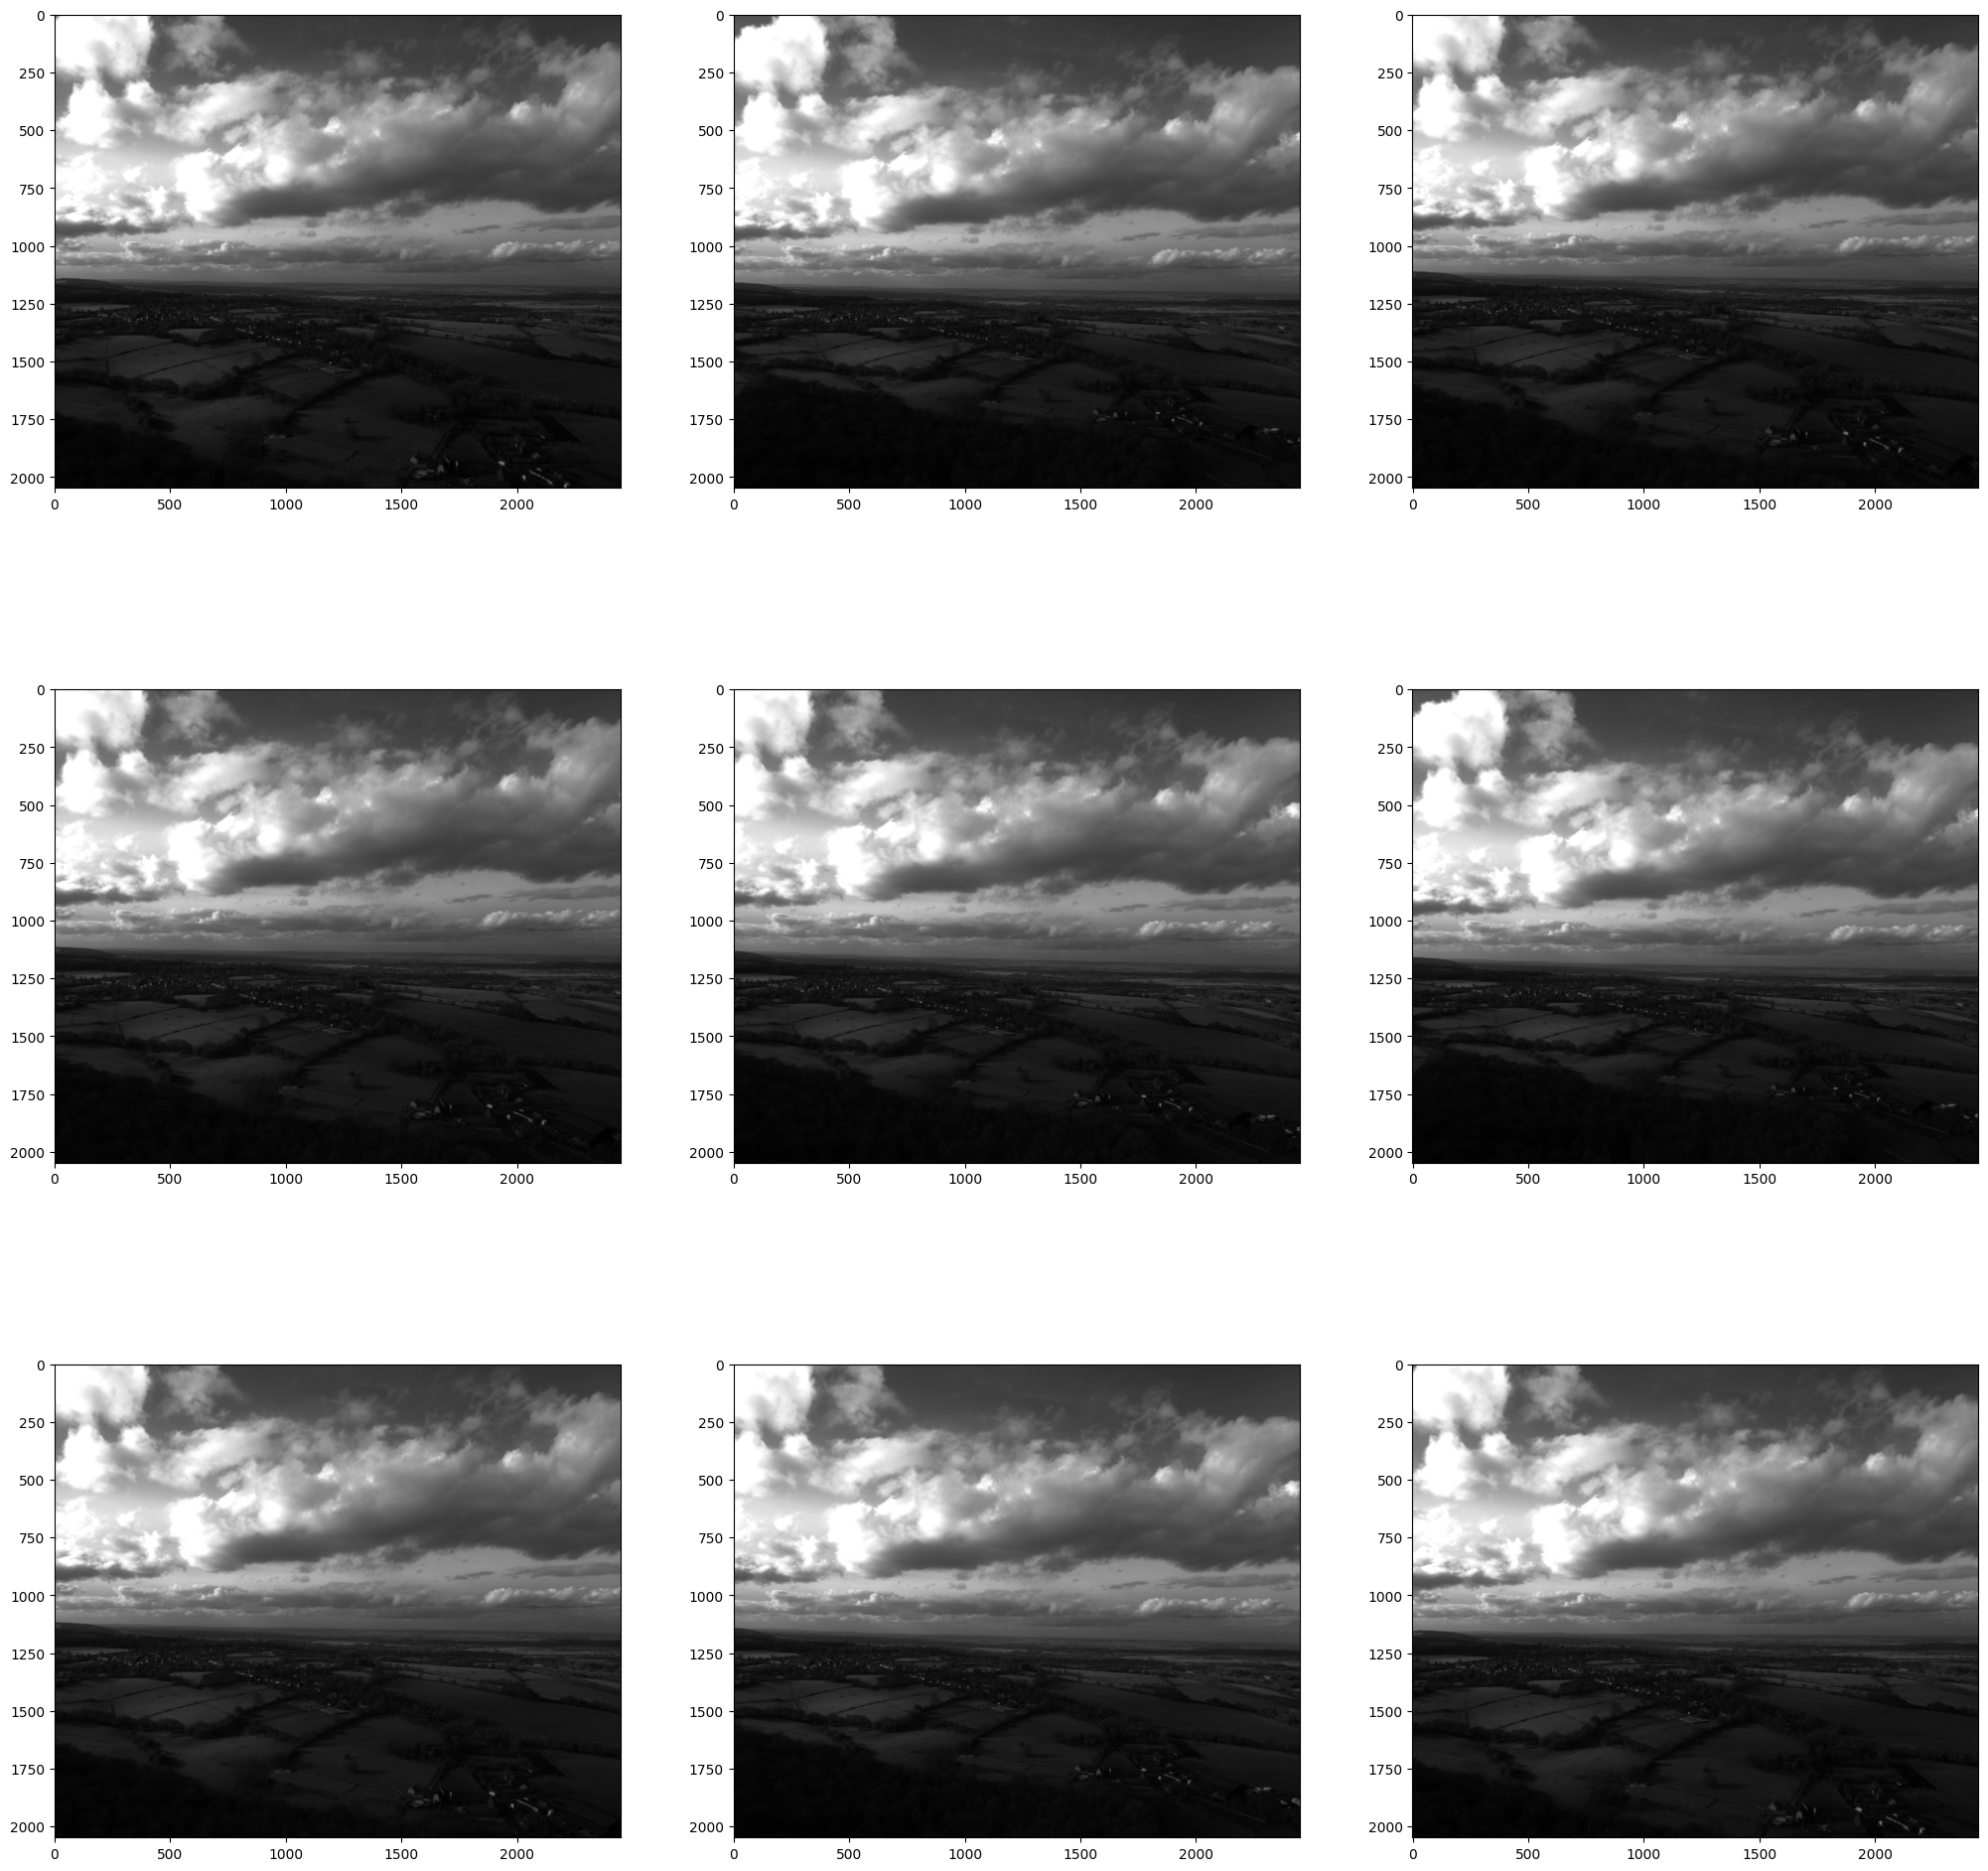

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=25,25
fig = plt.figure()

for i in range(1, 10):
    ax = fig.add_subplot(3, 3, i)
    ax.imshow(lucky_flight.get_frame(choice(list(lucky_flight.frames.keys()))).image(type='cv2'))

plt.show()

**Presence of the objects and distance in frames (when present)**

<Figure size 2000x2000 with 0 Axes>

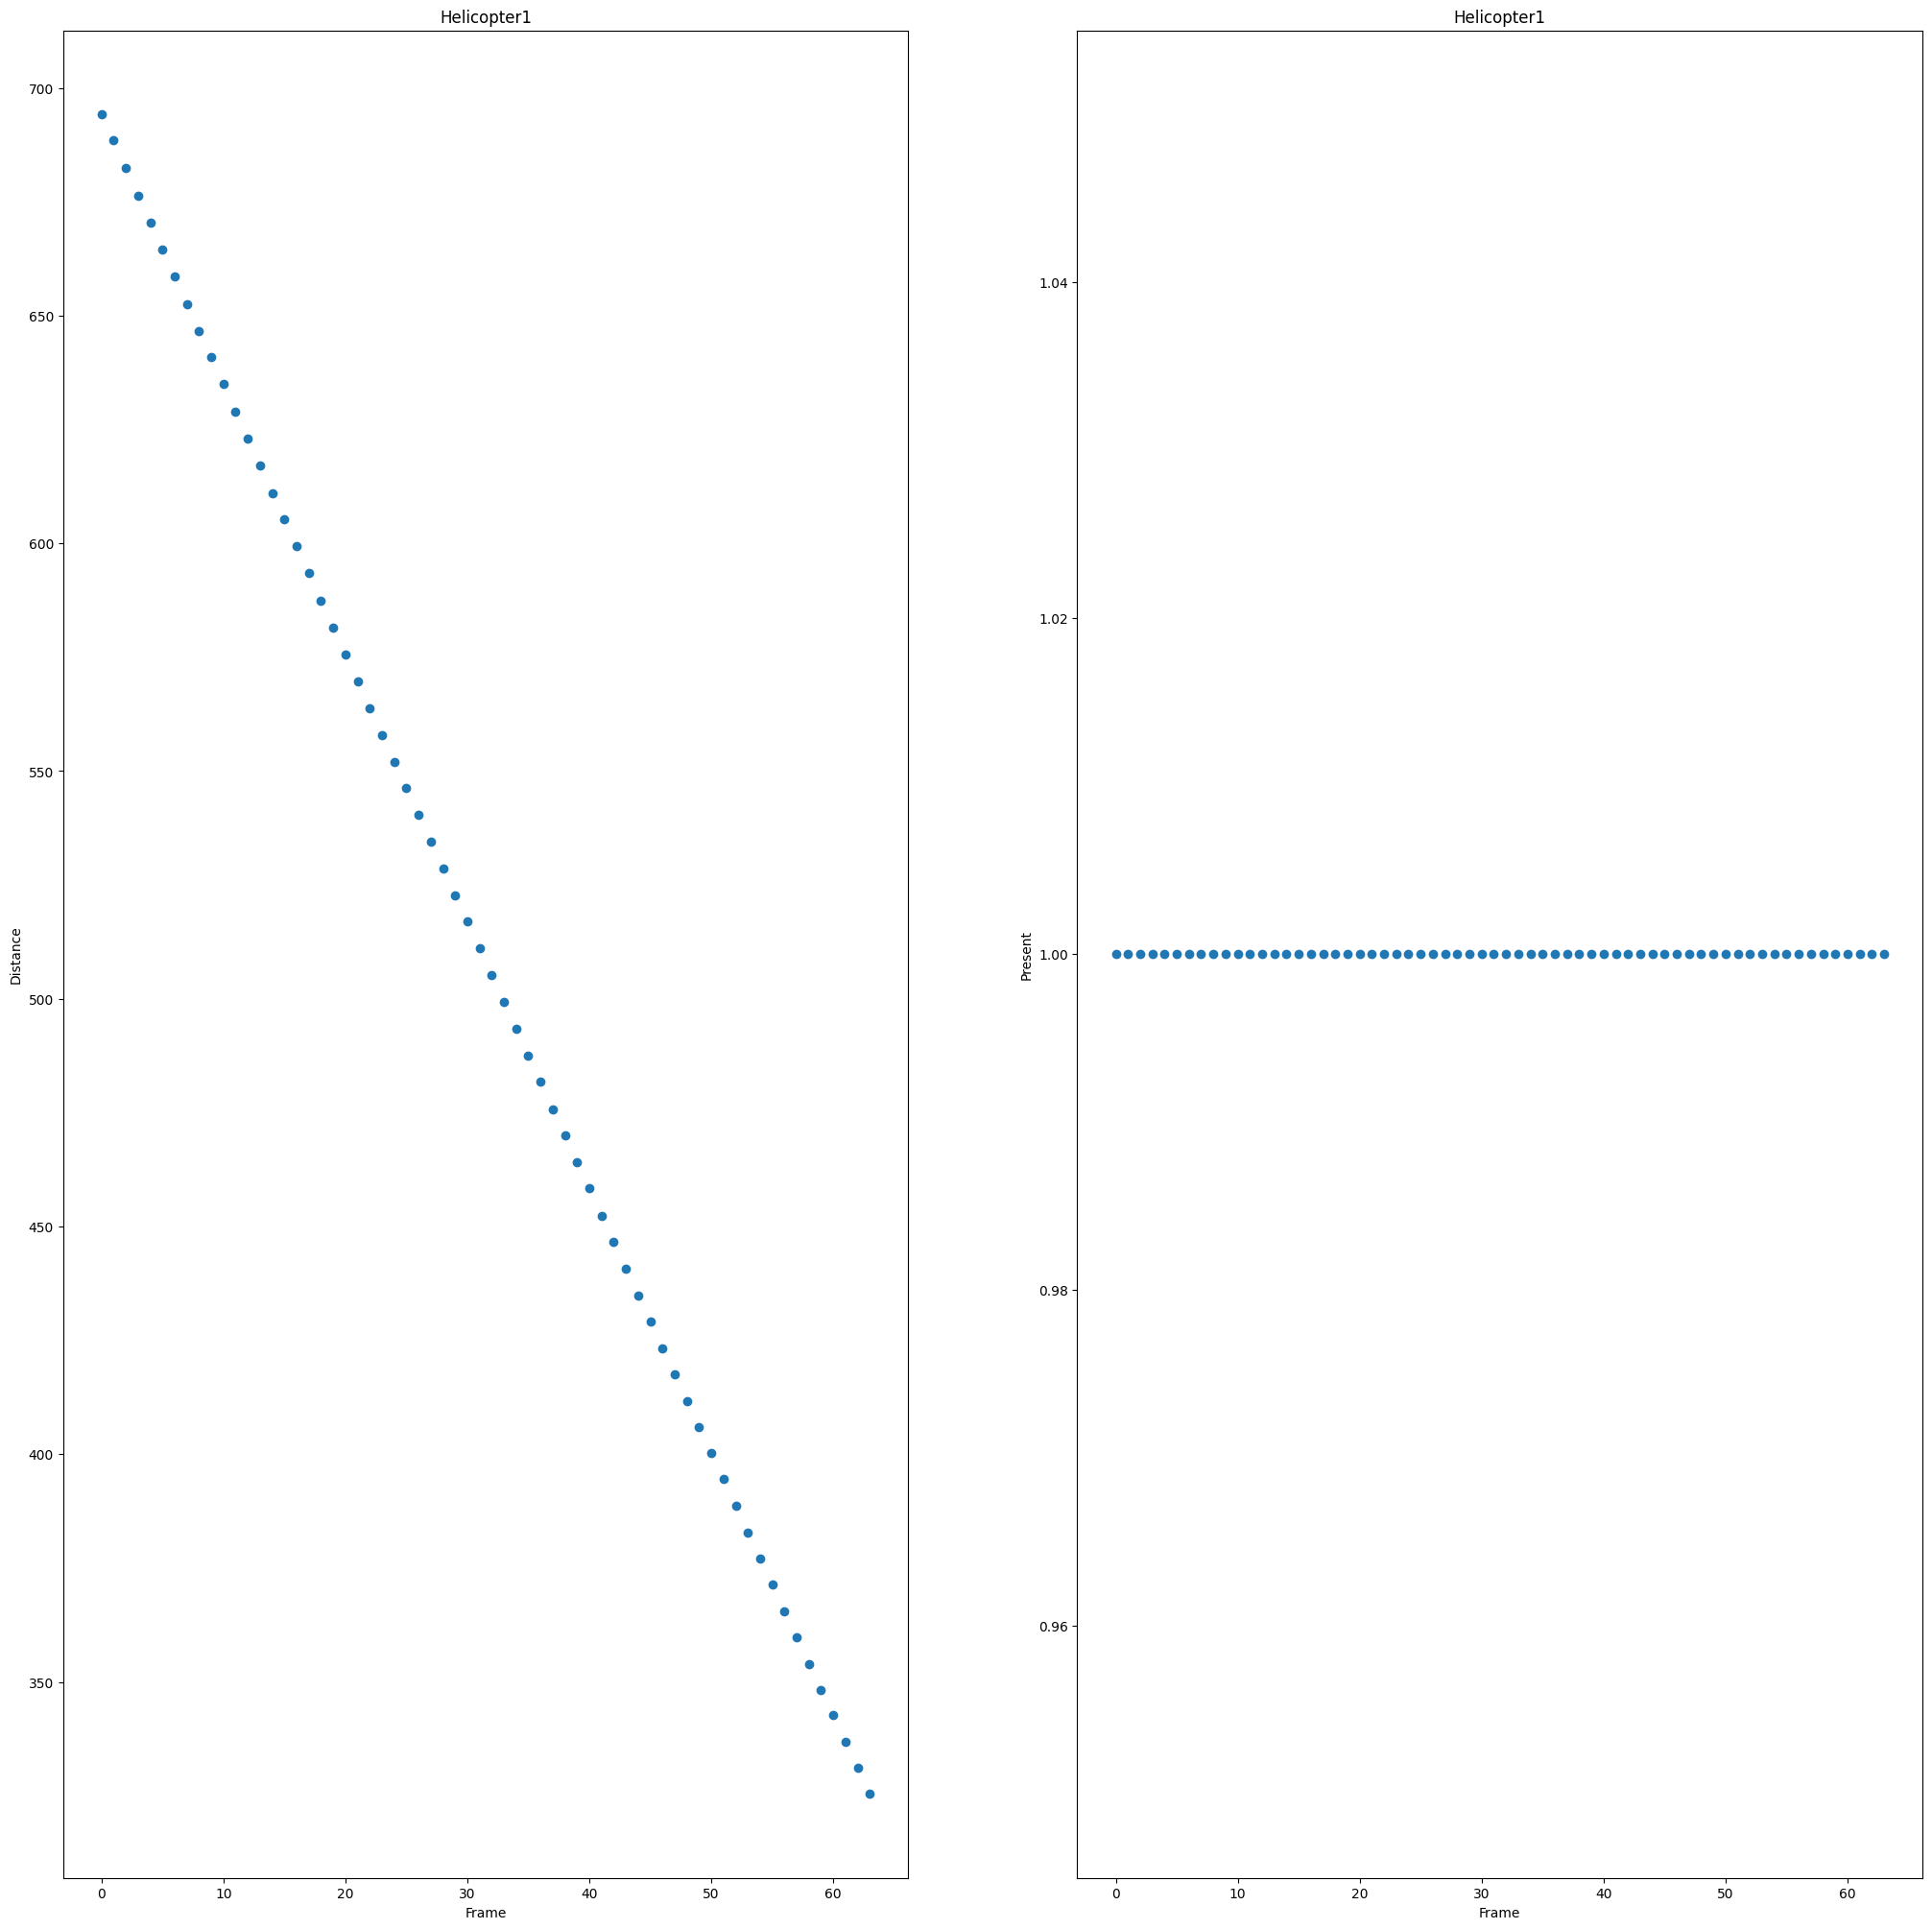

None

In [9]:
airborne_objects = lucky_flight.detected_objects
frames = lucky_flight.frames

rows = len(airborne_objects.keys())

detected = {}
distance = {}
for frame_id in lucky_flight.frames:
    f = lucky_flight.get_frame(frame_id)
    for obj in airborne_objects:
        if obj not in detected:
            detected[obj] = []
            distance[obj] = []

        if obj in f.detected_objects:
            detected[obj].append(True)
            distance[obj].append(f.detected_object_locations[obj].range_distance_m)
        else:
            detected[obj].append(False)
            if not airborne_objects[obj].planned:
                distance[obj].append(float("NaN"))
            else:
                distance[obj].append(0)

i = 0
f = plt.figure(figsize=(25, 25), dpi=80)
f, axes = plt.subplots(nrows = rows, ncols = 2, squeeze=False)

for obj in detected:
    axes[i][0].scatter(range(len(distance[obj])), distance[obj])
    axes[i][0].set_xlabel('Frame')
    axes[i][0].set_ylabel('Distance')
    axes[i][0].set_title(obj)

    if not airborne_objects[obj].planned:
        plt.text(0.3, 0.2, "Unplanned objects\ndon't have distance",
                 fontsize=20, transform=axes[i][0].transAxes, color="grey")

    axes[i][1].scatter(range(len(detected[obj])), detected[obj])
    axes[i][1].set_xlabel('Frame')
    axes[i][1].set_ylabel('Present')
    axes[i][1].set_title(obj)
    i += 1

display(plt.show())

2024-07-15 17:39:15.085 | INFO     | core.file_handler:download_file_if_needed:33 - [download_from_s3] File not found locally, downloading: Images/594bca9ad6fe4daa9f3df44c0b5e0775/1550588000592505897594bca9ad6fe4daa9f3df44c0b5e0775.png
2024-07-15 17:39:16.873 | INFO     | core.file_handler:download_file_if_needed:33 - [download_from_s3] File not found locally, downloading: Images/594bca9ad6fe4daa9f3df44c0b5e0775/1550587995364396561594bca9ad6fe4daa9f3df44c0b5e0775.png


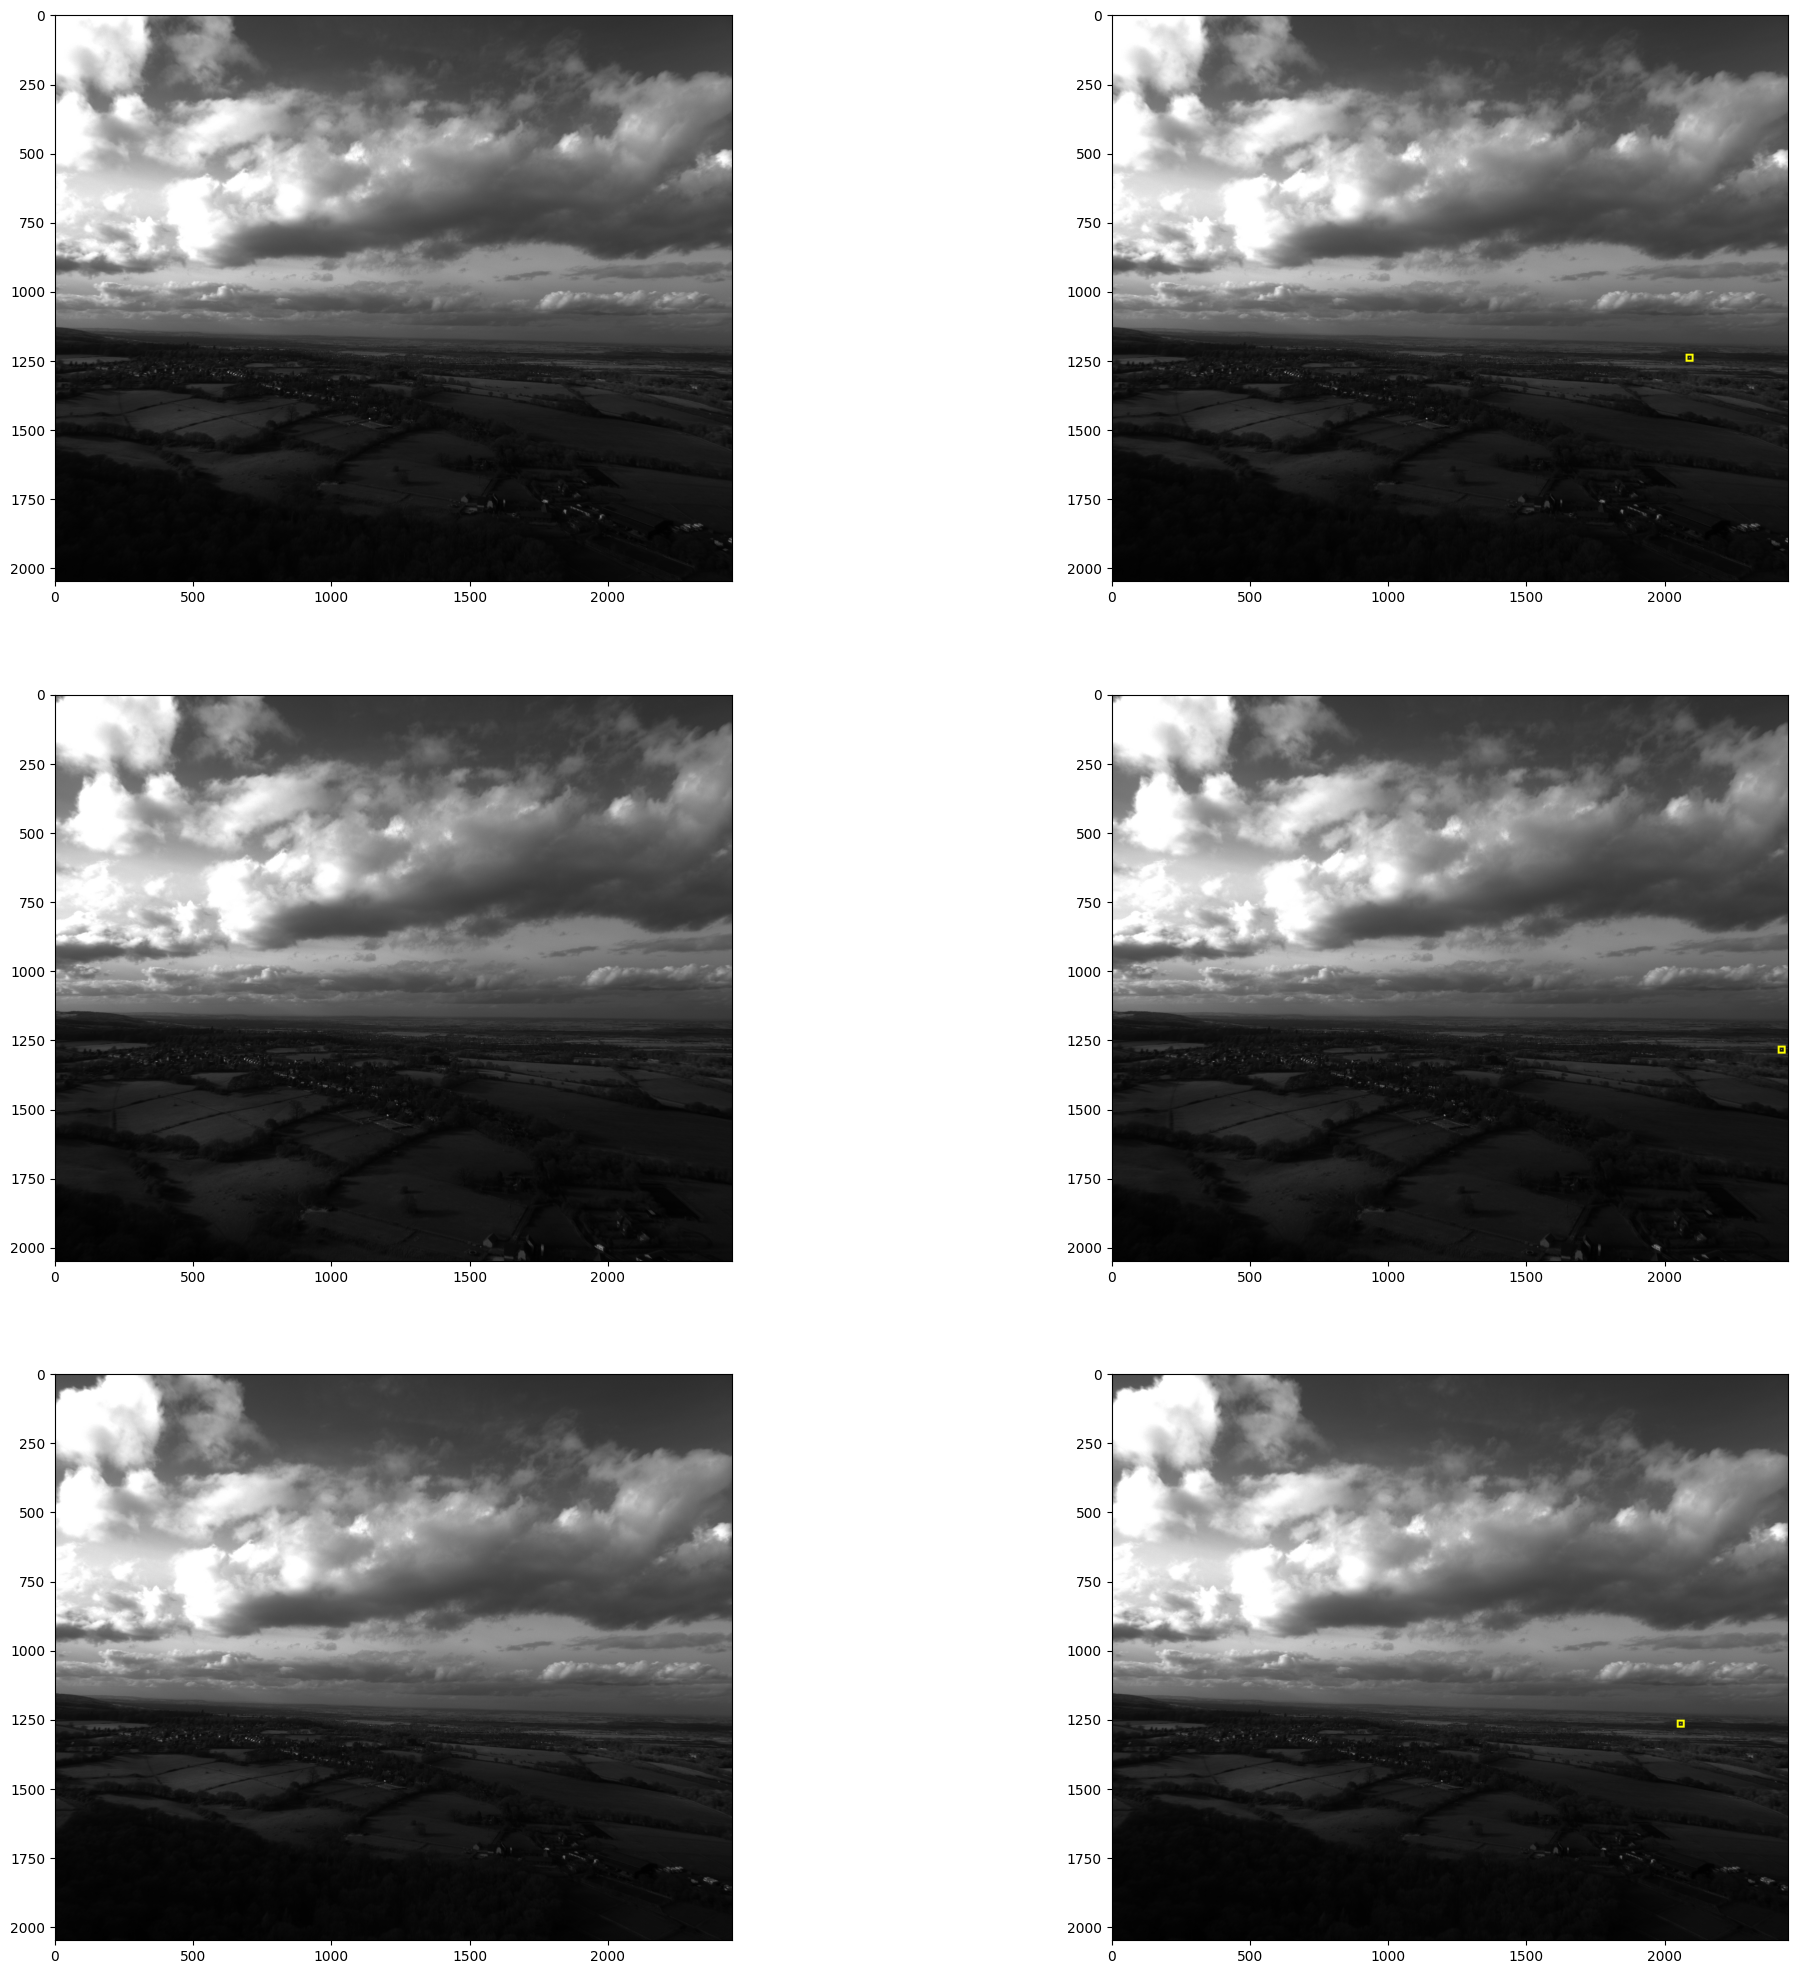

In [10]:
#%matplotlib inline
#import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"]=25,25

import time

# Let's get one of the "planned" object in this video
airborne_objects = lucky_flight.detected_objects
obj_of_interest = None
for obj in airborne_objects:
    if airborne_objects[obj].planned:
        obj_of_interest = airborne_objects[obj]
        break

images = []
fig = plt.figure()


for i in range(1, 7, 2):
    frame = obj_of_interest.location[randrange(obj_of_interest.num_frames)].frame
    ax = fig.add_subplot(3, 2, i)
    ax.imshow(frame.image(type='cv2'))
    ax = fig.add_subplot(3, 2, i + 1)
    ax.imshow(frame.image_annotated())

plt.show()

In [11]:
flight_path = lucky_flight.generate_video(speed_x=1)

# For rendering on Colab
# Colab have certain restrictions due to which you can't video large video files directly,
# but you can download instead...
from base64 import b64encode
mp4 = open(flight_path, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)


# or you can download the video file..
# from google.colab import files
# files.download(flight_path)

2024-07-15 17:39:34.924 | INFO     | core.flight:generate_video:129 - Generating video...


##Looking at some EDA:

### Overall Distribution for Partial Dataset

*Please use `partial=True` for getting correct distributions below!*

**Airborne Objects Count Distribution**

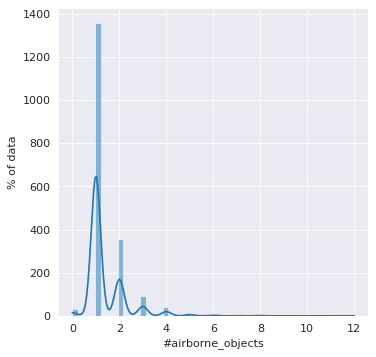

None

Avg:  1.400735294117647
Min:  0
Max:  12


In [12]:
num_objects = []
for flight_id in dataset.get_flight_ids():
    num_objects.append(dataset.get_flight(flight_id).num_airborne_objs)

plt.figure(figsize=(5, 5), dpi=80)
with sns.axes_style("darkgrid"):
  sns.histplot(num_objects, kde=True, bins=50)
plt.ylabel('% of data')
plt.xlabel('#airborne_objects')
display(plt.show())


print("Avg: ", sum(num_objects) / len(num_objects))
print("Min: ", min(num_objects))
print("Max: ", max(num_objects))

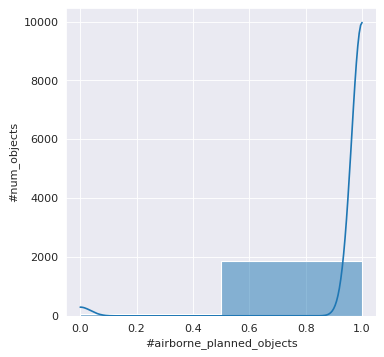

None

Min:  0
Max:  1


In [13]:
planned_num_objects = []
for flight_id in dataset.get_flight_ids():
    count = 0
    flight = dataset.get_flight(flight_id)
    for obj in flight.detected_objects:
        if flight.detected_objects[obj].planned:
            count += 1

    planned_num_objects.append(count)

plt.figure(figsize=(5, 5), dpi=80)
with sns.axes_style("darkgrid"):
  sns.histplot(planned_num_objects, kde=True, bins=2)
plt.ylabel('#num_objects')
plt.xlabel('#airborne_planned_objects')
display(plt.show())


print("Min: ", min(planned_num_objects))
print("Max: ", max(planned_num_objects))

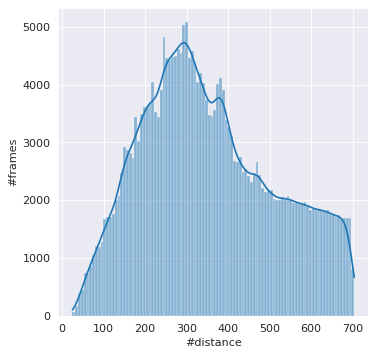

None

Avg:  356.1235995343265
Min:  25.047192232022347
Max:  703.5743826104314


In [14]:
obj_distance = []

for flight_id in dataset.get_flight_ids():
    flight = dataset.get_flight(flight_id)
    for obj in flight.detected_objects:
        if flight.detected_objects[obj].planned:
            for loc in flight.detected_objects[obj].location:
                obj_distance.append(loc.range_distance_m)

plt.figure(figsize=(5, 5), dpi=80)
with sns.axes_style("darkgrid"):
  sns.histplot(obj_distance, kde=True, bins=100)
plt.ylabel('#frames')
plt.xlabel('#distance')
display(plt.show())

print("Avg: ", sum(obj_distance) / len(obj_distance))
print("Min: ", min(obj_distance))
print("Max: ", max(obj_distance))

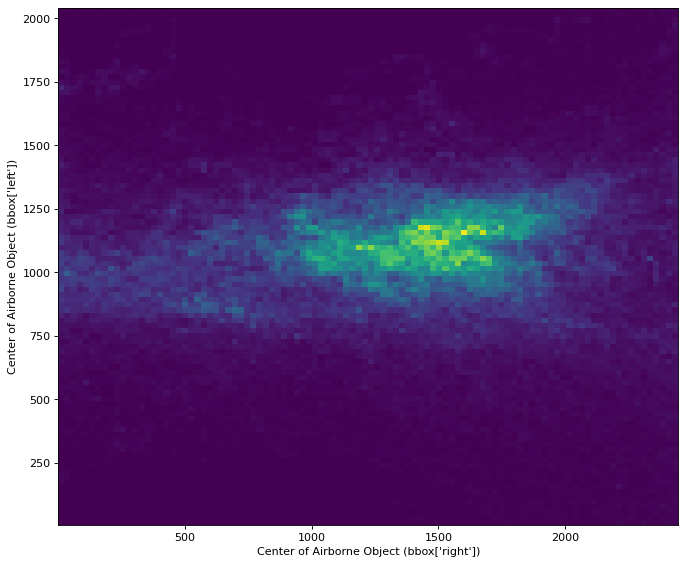

In [15]:
obj_center_left = []
obj_center_top = []

for flight_id in dataset.get_flight_ids():
    flight = dataset.get_flight(flight_id)
    for obj in flight.detected_objects:
        if flight.detected_objects[obj].planned:
            for loc in flight.detected_objects[obj].location:
                left, top = loc.bb.get_center()
                obj_center_left.append(left)
                obj_center_top.append(top)

heatmap, xedges, yedges = np.histogram2d(obj_center_left, obj_center_top, bins=100)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure(figsize=(10, 10), dpi=80)
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.ylabel("Center of Airborne Object (bbox['left'])")
plt.xlabel("Center of Airborne Object (bbox['right'])")
plt.show()

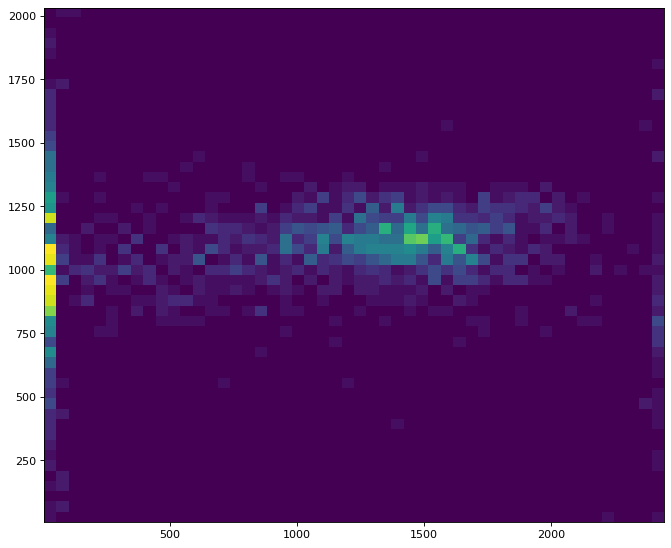

In [16]:
# Entry
# From where the Airborne objects generally start in whole flight
# Based on data it definitely looks like it come from left most of the times...

obj_center_left_entry = []
obj_center_top_entry = []

for flight_id in dataset.get_flight_ids():
    flight = dataset.get_flight(flight_id)
    for obj in flight.detected_objects:
        if flight.detected_objects[obj].planned:
            for loc in flight.detected_objects[obj].location:
                left, top = loc.bb.get_center()
                obj_center_left_entry.append(left)
                obj_center_top_entry.append(top)
                break

heatmap, xedges, yedges = np.histogram2d(obj_center_left_entry, obj_center_top_entry, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure(figsize=(10, 10), dpi=80)
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

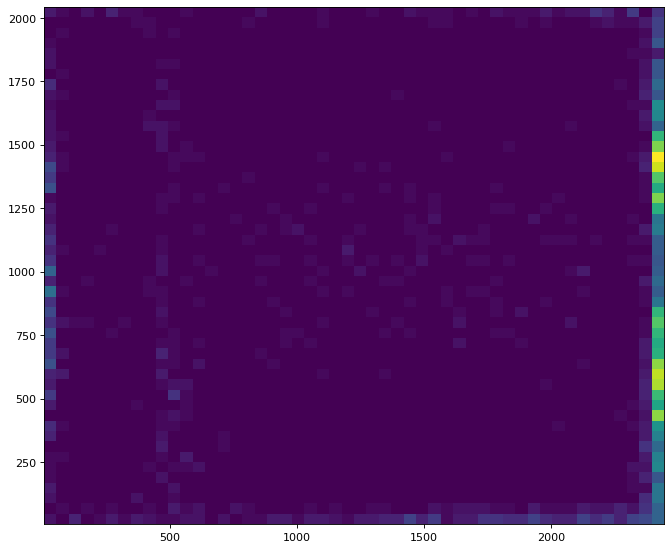

In [17]:
# Exit
# From where the Airborne objects generally exit in whole flight
# Based on data it definitely looks like it come from left and **leave** at right most of the times...
obj_center_left_entry = []
obj_center_top_entry = []

for flight_id in dataset.get_flight_ids():
    flight = dataset.get_flight(flight_id)
    for obj in flight.detected_objects:
        if flight.detected_objects[obj].planned:
            loc = flight.detected_objects[obj].location[-1]
            left, top = loc.bb.get_center()
            obj_center_left_entry.append(left)
            obj_center_top_entry.append(top)

heatmap, xedges, yedges = np.histogram2d(obj_center_left_entry, obj_center_top_entry, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure(figsize=(10, 10), dpi=80)
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

### Overall Distribution

*Please use `partial=False` for getting correct distributions below!*

#### Airborne Objects Count Distribution

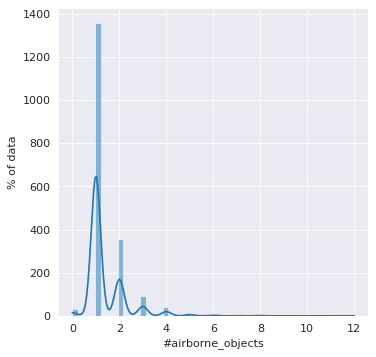

None

Avg:  1.400735294117647
Min:  0
Max:  12


In [18]:
num_objects = []
for flight_id in dataset.get_flight_ids():
    num_objects.append(dataset.get_flight(flight_id).num_airborne_objs)

plt.figure(figsize=(5, 5), dpi=80)
with sns.axes_style("darkgrid"):
  sns.histplot(num_objects, kde=True, bins=50)
plt.ylabel('% of data')
plt.xlabel('#airborne_objects')
display(plt.show())


print("Avg: ", sum(num_objects) / len(num_objects))
print("Min: ", min(num_objects))
print("Max: ", max(num_objects))

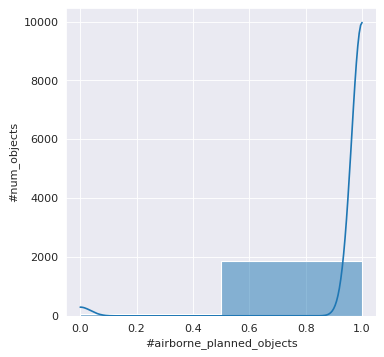

None

Min:  0
Max:  1


In [19]:
planned_num_objects = []
for flight_id in dataset.get_flight_ids():
    count = 0
    flight = dataset.get_flight(flight_id)
    for obj in flight.detected_objects:
        if flight.detected_objects[obj].planned:
            count += 1

    planned_num_objects.append(count)

plt.figure(figsize=(5, 5), dpi=80)
with sns.axes_style("darkgrid"):
  sns.histplot(planned_num_objects, kde=True, bins=2)
plt.ylabel('#num_objects')
plt.xlabel('#airborne_planned_objects')
display(plt.show())


print("Min: ", min(planned_num_objects))
print("Max: ", max(planned_num_objects))

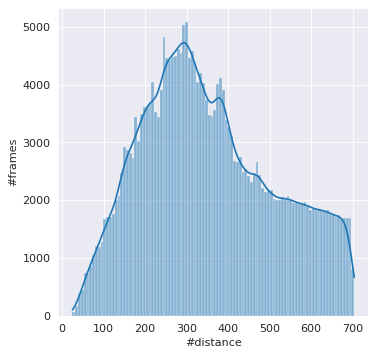

None

Avg:  356.1235995343265
Min:  25.047192232022347
Max:  703.5743826104314


In [20]:
obj_distance = []

for flight_id in dataset.get_flight_ids():
    flight = dataset.get_flight(flight_id)
    for obj in flight.detected_objects:
        if flight.detected_objects[obj].planned:
            for loc in flight.detected_objects[obj].location:
                obj_distance.append(loc.range_distance_m)

plt.figure(figsize=(5, 5), dpi=80)
with sns.axes_style("darkgrid"):
  sns.histplot(obj_distance, kde=True, bins=100)
plt.ylabel('#frames')
plt.xlabel('#distance')
display(plt.show())

print("Avg: ", sum(obj_distance) / len(obj_distance))
print("Min: ", min(obj_distance))
print("Max: ", max(obj_distance))

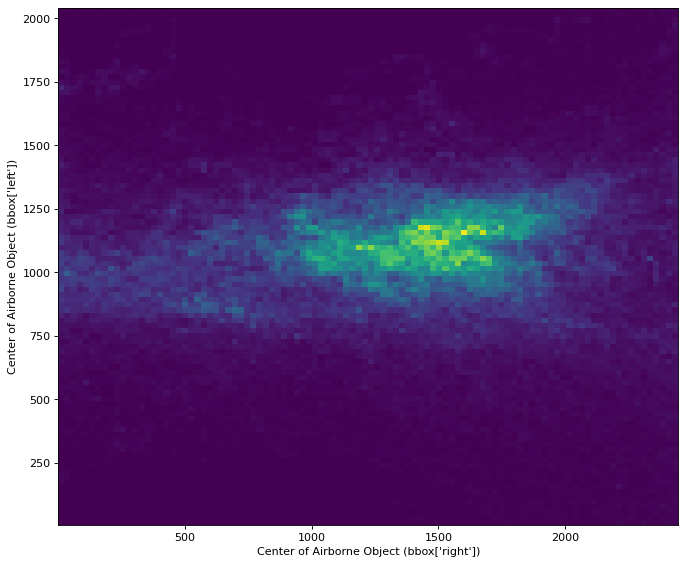

In [21]:
obj_center_left = []
obj_center_top = []

for flight_id in dataset.get_flight_ids():
    flight = dataset.get_flight(flight_id)
    for obj in flight.detected_objects:
        if flight.detected_objects[obj].planned:
            for loc in flight.detected_objects[obj].location:
                left, top = loc.bb.get_center()
                obj_center_left.append(left)
                obj_center_top.append(top)

heatmap, xedges, yedges = np.histogram2d(obj_center_left, obj_center_top, bins=100)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure(figsize=(10, 10), dpi=80)
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.ylabel("Center of Airborne Object (bbox['left'])")
plt.xlabel("Center of Airborne Object (bbox['right'])")
plt.show()

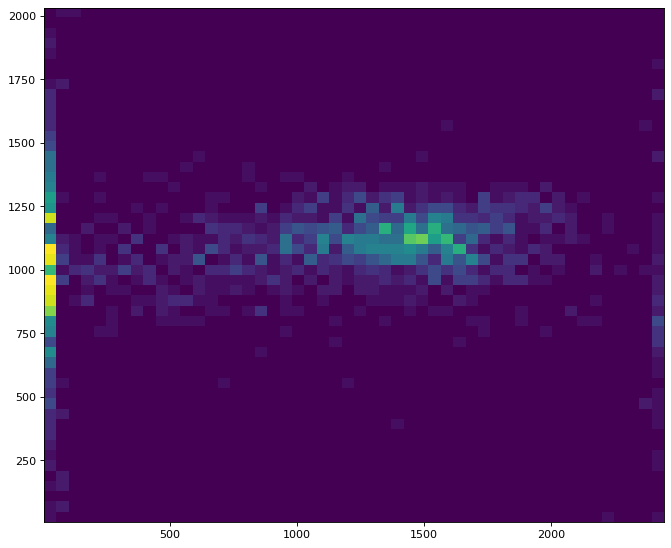

In [22]:
# Entry
# From where the Airborne objects generally start in whole flight
# Based on data it definitely looks like it come from left most of the times...

obj_center_left_entry = []
obj_center_top_entry = []

for flight_id in dataset.get_flight_ids():
    flight = dataset.get_flight(flight_id)
    for obj in flight.detected_objects:
        if flight.detected_objects[obj].planned:
            for loc in flight.detected_objects[obj].location:
                left, top = loc.bb.get_center()
                obj_center_left_entry.append(left)
                obj_center_top_entry.append(top)
                break

heatmap, xedges, yedges = np.histogram2d(obj_center_left_entry, obj_center_top_entry, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure(figsize=(10, 10), dpi=80)
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

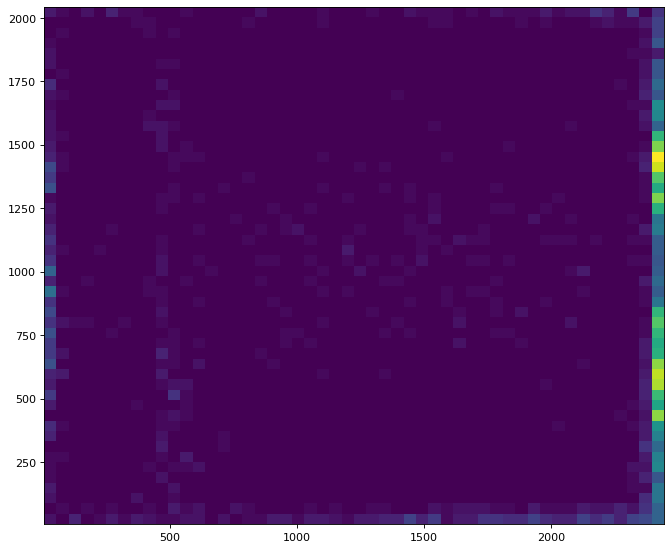

In [23]:
# Exit
# From where the Airborne objects generally exit in whole flight
# Based on data it definitely looks like it come from left and **leave** at right most of the times...
obj_center_left_entry = []
obj_center_top_entry = []

for flight_id in dataset.get_flight_ids():
    flight = dataset.get_flight(flight_id)
    for obj in flight.detected_objects:
        if flight.detected_objects[obj].planned:
            loc = flight.detected_objects[obj].location[-1]
            left, top = loc.bb.get_center()
            obj_center_left_entry.append(left)
            obj_center_top_entry.append(top)

heatmap, xedges, yedges = np.histogram2d(obj_center_left_entry, obj_center_top_entry, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure(figsize=(10, 10), dpi=80)
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

### Forking this notebook to add more explorations.

In [31]:
from core.helper import *

# Initialize the enviroment
initialize(42)

# Loading the dataset and save to a variable
# Whether you want to load the entire dataset, use partial=False
dataset = load_data()

# Print out the dataset
print(dataset)

2024-07-15 18:02:23.894 | INFO     | core.dataset:load_gt:28 - Loading ground truth...
2024-07-15 18:03:07.527 | INFO     | core.dataset:load_gt:28 - Loading ground truth...
2024-07-15 18:03:46.023 | INFO     | core.dataset:load_gt:28 - Loading ground truth...


Dataset(num_flights=3438)


In [32]:
print(type(dataset))

<class 'core.dataset.Dataset'>


In [41]:
# Assuming dataset is an instance of core.dataset.Dataset

# Print list of attributes and methods
print("dir():")
print(dir(dataset))

# Print the dictionary of the dataset's attributes
print("\nvars():")
print(vars(dataset))

# Print the __dict__ attribute
print("\n__dict__:")
print(dataset.__dict__)

# Print the detailed help
print("\nhelp():")
help(dataset)

# Print detailed information using inspect
print("\ninspect.getmembers():")
import inspect
print(inspect.getmembers(dataset))


dir():
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'add', 'file_handler', 'flights', 'get_flight', 'get_flight_by_id', 'get_flight_ids', 'gt_loc', 'load_gt', 'load_ve', 'metadata', 'partial', 'prefix', 'valid_encounter', 'valid_encounters_loc']

vars():
{'file_handler': <core.file_handler.FileHandler object at 0x7b78c76fd3f0>, 'partial': False, 'valid_encounter': {}, 'prefix': None, 'metadata': {'description': 'camera1', 'last_modified': 'Jan-08-2021 21:17:22', 'version': '1.0'}}

__dict__:
{'file_handler': <core.file_handler.FileHandler object at 0x7b78c76fd3f0>, 'partial': False, 'valid_encounter': {}, 'prefix': None, 'metadata': {'description': 'camera1', 'last_modified': 'Jan-08-2021 21

## Converting dataset to dataframe:

In [45]:
def remove_numbers(s):
  return ''.join([i for i in s if not i.isdigit()])

all_keys = []
for flight_id in dataset.get_flight_ids():
    flight = dataset.get_flight(flight_id)
    all_keys.extend([remove_numbers(k) for k in flight.detected_objects])

unique_keys = list(set(all_keys))
unique_keys

['Airplane', 'Airborne', 'Flock', 'Helicopter', 'Drone', 'Bird']

In [46]:
rows = []
for flight_id in dataset.get_flight_ids():
    flight = dataset.get_flight(flight_id)
    for obj_key in flight.detected_objects:
        object_type = remove_numbers(obj_key)
        obj = flight.detected_objects[obj_key]
        for loc in obj.location:
            bbox = loc.bb.get_bbox()
            frame_id = loc.frame.id
            range_distance = loc.range_distance_m
            image_path = loc.frame.image_path()
            rows.append([flight_id, object_type, obj_key, frame_id,
                         *bbox, bbox[-1]*bbox[-2], image_path, range_distance])

In [47]:
import pandas as pd
# converting the rows array to a dataframe
df = pd.DataFrame(rows)
df.columns = ['flight_id', 'object_type', 'object', 'frame_id',
              'left', 'top', 'width', 'height', 'area', 'image_path','range_distance']
df.head()

flight_id object_type     object  frame_id  \
0  00bb96a5a68f4fa5bc5c5dc66ce314d2    Airplane  Airplane1       188   
1  00bb96a5a68f4fa5bc5c5dc66ce314d2    Airplane  Airplane1       189   
2  00bb96a5a68f4fa5bc5c5dc66ce314d2    Airplane  Airplane1       190   
3  00bb96a5a68f4fa5bc5c5dc66ce314d2    Airplane  Airplane1       191   
4  00bb96a5a68f4fa5bc5c5dc66ce314d2    Airplane  Airplane1       192   

        left     top       width  height         area  \
0   3.400000  1312.6   32.400000    11.6   375.840000   
1   3.404559  1320.2   73.995441    44.8  3314.995772   
2   3.404559  1324.2  115.595441    52.2  6034.082043   
3   3.004558  1326.2  162.395442    54.2  8801.832931   
4  47.523492  1335.2  165.476508    55.6  9200.493871   

                                          image_path  range_distance  
0  Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...      179.178353  
1  Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...      173.604451  
2  Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...      168.125379  
3  Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...      162.657440  
4  Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...      157.507999

###EDA:

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2312262 entries, 0 to 2312261
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   flight_id       object 
 1   object_type     object 
 2   object          object 
 3   frame_id        int64  
 4   left            float64
 5   top             float64
 6   width           float64
 7   height          float64
 8   area            float64
 9   image_path      object 
 10  range_distance  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 194.1+ MB


In [49]:
df.describe()

frame_id          left           top         width        height  \
count  2.312262e+06  2.312262e+06  2.312262e+06  2.312262e+06  2.312262e+06   
mean   5.758232e+02  1.220994e+03  9.049987e+02  1.601170e+01  1.282479e+01   
std    3.354459e+02  5.857159e+02  3.107863e+02  4.093310e+01  1.830630e+01   
min    2.000000e+00  0.000000e+00  0.000000e+00  1.400000e+00  1.400000e+00   
25%    2.890000e+02  8.068190e+02  7.272077e+02  6.000000e+00  6.000000e+00   
50%    5.660000e+02  1.250991e+03  9.612966e+02  1.400000e+01  6.852112e+00   
75%    8.570000e+02  1.638583e+03  1.110275e+03  1.600000e+01  1.600000e+01   
max    1.202000e+03  2.445000e+03  2.045000e+03  2.436631e+03  1.232231e+03   

               area  range_distance  
count  2.312262e+06    1.085460e+06  
mean   8.545766e+02    1.478421e+03  
std    2.218396e+04    1.145123e+03  
min    6.000000e+00    5.905806e+00  
25%    3.600000e+01    5.937808e+02  
50%    1.325568e+02    1.179687e+03  
75%    2.560000e+02    2.063207e+03  
max    2.803834e+06    9.399926e+03

In [50]:
df.shape

(2312262, 11)

In [51]:
object_types = df['object_type'].value_counts()
object_types

object_type
Helicopter    952496
Airplane      627699
Airborne      452032
Bird          265027
Flock          13234
Drone           1774
Name: count, dtype: int64

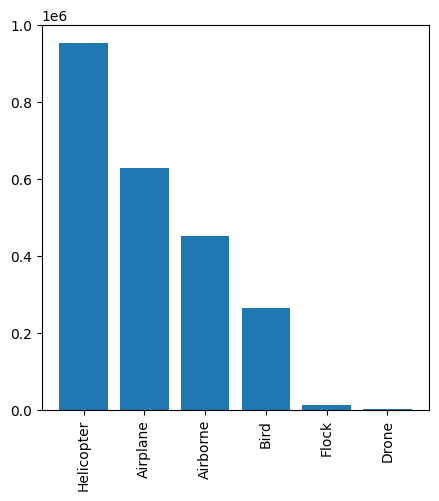

In [58]:
plt.bar(object_types.index, object_types.values)
plt.rcParams['figure.figsize'] = [3, 3]
plt.xticks(rotation=90)
plt.show()

### Checking for any necessary data cleaning:

In [54]:
# Checking for null values
pd.DataFrame(df.isna().sum(), columns=['count'])

count
flight_id             0
object_type           0
object                0
frame_id              0
left                  0
top                   0
width                 0
height                0
area                  0
image_path            0
range_distance  1226802

In [55]:
#Checking for duplicates
df.duplicated().sum()

0